# Mode Population Coverage
This notebook treats how much a mode covers a population: for which part is it the fastest option, which part of the population is able to reach the center in x minutes, etc! See below.

# Imports, Methods & Data
These are automatically executed using the initialisation-cells plugin.

In [30]:
import json
import requests
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import os.path
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from math import ceil
from collections import defaultdict
from pyproj import CRS

import seaborn as sns
sns.set()

import contextily as ctx

from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline

DROOT = './data'

/Users/ivo/opt/anaconda3/envs/thesis-env/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [31]:
def set_parktime(gdf_original, parking_time, humancols=False, minutes=False):
    """Returns a new copy of dataframe with the set parking_time."""

    # Check if a valid gdf_original
    modes_r = ['bike_t', 'car_r_t', 'pt_r_t', 'walk_t']
    modes_m = ['bike_t', 'car_m_t', 'pt_m_t', 'walk_t']

    required = [col in gdf_original.columns for col in (modes_r + modes_m)]
    if np.array(required).sum() != len(required):
        raise ValueError("Not all required columns provided.")

    # Build new copy of the original map, returning it later.
    new_gdf = gdf_original.copy()
    new_gdf.car_r_t = gdf_original.car_r_t + parking_time
    new_gdf.car_m_t = gdf_original.car_m_t + parking_time

    # Get fastest mode in rush hour and midday per cell.
    modes_r = ['bike_t', 'car_r_t', 'pt_r_t', 'walk_t']
    modes_m = ['bike_t', 'car_m_t', 'pt_m_t', 'walk_t']
    new_gdf['recmode_r'] = new_gdf[modes_r].idxmin(1)
    new_gdf['recmode_m'] = new_gdf[modes_m].idxmin(1)

    # Rename column values so we don't mix them up next.
    new_gdf.recmode_r.replace({'bike_t': 'bike_r_t',
                               'walk_t': 'walk_r_t'}, inplace=True)
    new_gdf.recmode_m.replace({'bike_t': 'bike_m_t',
                               'walk_t': 'walk_m_t'}, inplace=True)
    
    # If statistics are requested in minutes, convert them.
    if minutes:
        new_gdf[route_cols] = (new_gdf[route_cols] / 60).round(1)
    
    return new_gdf


In [32]:
# Load Cities transport times.
gdf_original = gpd.read_file(
    os.path.join(DROOT, '4-processed', 'complete-dataset.gpkg'))
gdf_total = gdf_original.copy()

In [33]:
# Define the columns containing population percentages.
pop_cols = ['bike_pop', 'pt_r_pop', 'pt_m_pop', 'car_r_pop', 'car_m_pop', 'walk_pop']

# Procedures

## Finding the relative population coverage per mode

**rel-pop-reached/rel-pop-reached-pt{1}min-tb{2}min.csv**

Describes which relative part of the population is reached within {1} minutes of time budget, considering a parking time for cars of {2} minutes. Rounded off to 2 digits.

* city: main cityname key, index
* bike_pop: bike.
* car_pop: car
* pt_pop: public transport
* bike_pop: bike.
* car_pop: car
* pt_pop: public transport

In [9]:
surface_stats = pd.read_csv(os.path.join(DROOT, '3-interim', 'citystats.csv'), 
                            index_col='city', usecols=['city', 'covered_pop'])

In [10]:
parktime_timebudget = []
for pt in np.arange(0, 750, 150):
    for tb in np.arange(60, 2460, 60):
        parktime_timebudget.append((pt, tb))

# Generate working directory
os.makedirs(os.path.join(DROOT, '4-processed', 'rel-pop-reached'), exist_ok=True)

iterator = tqdm(parktime_timebudget, leave=False)
for pt, tb in iterator:
    
    iterator.set_description(f'pt:{pt:4}, tb:{tb:4}')
    
    gdf_padd = gdf_original.copy().set_index('city')
    gdf_padd[['car_r_t', 'car_m_t']] += 450
    
    city_props = pd.DataFrame({
        'bike_pop':  gdf_padd[gdf_padd.bike_t  <= tb].groupby('city').cell_pop.sum(),
        'pt_r_pop':  gdf_padd[gdf_padd.pt_r_t  <= tb].groupby('city').cell_pop.sum(),
        'pt_m_pop':  gdf_padd[gdf_padd.pt_m_t  <= tb].groupby('city').cell_pop.sum(),
        'car_r_pop': gdf_padd[gdf_padd.car_r_t <= tb].groupby('city').cell_pop.sum(),
        'car_m_pop': gdf_padd[gdf_padd.car_m_t <= tb].groupby('city').cell_pop.sum(),
        'walk_pop':  gdf_padd[gdf_padd.walk_t  <= tb].groupby('city').cell_pop.sum(),
    })

    # Set covered pop to the total population inside the radius.
    city_props['covered_pop'] = surface_stats['covered_pop']

    # Divide all columns by the total populations
    city_props[pop_cols] = city_props[pop_cols].apply(
        lambda col: col / city_props.covered_pop * 100)

    # Set n_consid to amount of cells considered.
    city_props['n_consid'] = gdf_padd.groupby('city').size()

    # Because the index is taken over implicitly, set to explicit.
    city_props.index.name = 'city'
    city_props = city_props.sort_values(by='bike_pop', ascending=False)
 
    # Write out iteration to result files.
    city_props.to_csv(
        os.path.join(DROOT, '4-processed', 'rel-pop-reached', 
                     f'rel-pop-reached-pt{pt / 60}min-tb{int(tb / 60)}min.csv'))

# Show the last generated
city_props[city_props.n_consid > 1500].head(5)

,bike_pop,pt_r_pop,pt_m_pop,car_r_pop,car_m_pop,walk_pop,covered_pop,n_consid
city,,,,,,,,
Copenhagen,98.651319,94.401938,95.748014,99.888227,99.900894,27.856934,9.356953e+05,3090
Brussels,98.153874,69.571272,71.670364,79.830658,98.325346,27.361576,1.321532e+06,3747
Gothenburg,97.192847,96.610210,95.973240,99.937057,99.937057,27.387873,4.635215e+05,2637
Adelaide,95.509032,74.431062,85.843260,99.997528,99.997528,7.837910,5.521023e+05,4184
Stockholm,94.989024,53.148596,55.089265,99.963913,99.969341,24.221142,9.823008e+05,3669


## Collect the relative amount of population per fastest mode choice.
**relative-pop-fastest-mode/rpf-{time}-pt{1}min.csv**

This file-collection describes the percentage covered by a certain population percentage with a {1} seconds waiting-time included for motorised travel. Split up in granularity of 30 seconds to allow static file hosting for website.

The file is two-parters with the same columns.

* city: main cityname key, index
* bike_t: percentage of population fastest on bike in rush hour.
* car_t: car
* pt_t: public transport

In [26]:
total = gdf_total.groupby('city').cell_pop.sum()

# Generate working directory
os.makedirs(os.path.join(DROOT, '4-processed',
                         'rel-pop-fastest-mode'), exist_ok=True)

iterator = tqdm(range(0, 930, 30), leave=False)
for pt in iterator:

    gdf_total = set_parktime(gdf_original, pt)
    iterator.set_description(f'pt={pt:3}')

    # Create dataframe from dictionary and sort on bikes.
    df_r = gdf_total.groupby(['city', 'recmode_r']
                             ).cell_pop.sum() / total * 100
    df_r = df_r.unstack(-1)
    df_r = df_r.fillna(0)
    df_r = df_r.sort_values('bike_r_t', ascending=False)
    df_r = df_r.drop(columns=['walk_r_t'])
    df_r.index.name = 'city'
    df_r.to_csv(os.path.join(
        DROOT, '4-processed', 'rel-pop-fastest-mode',
                             f'rpf-r-pt{(pt / 60):.1f}min.csv'))
    df_r.T.to_json(os.path.join(
        DROOT, '4-processed', 'rel-pop-fastest-mode',
                             f'rpf-r-pt{(pt / 60):.1f}min.json'))

    df_m = gdf_total.groupby(['city', 'recmode_m']
                             ).cell_pop.sum() / total * 100
    df_m = df_m.unstack(-1)
    df_m = df_m.fillna(0)
    df_m = df_m.sort_values('bike_m_t', ascending=False)
    df_m = df_m.drop(columns=['walk_m_t'])
    df_m.index.name = 'city'
    df_m.to_csv(os.path.join(
        DROOT, '4-processed', 'rel-pop-fastest-mode',
                             f'rpf-m-pt{(pt / 60):.1f}min.csv'))
    df_m.to_json(os.path.join(
        DROOT, '4-processed', 'rel-pop-fastest-mode',
                                f'rpf-m-pt{(pt / 60):.1f}min.json'))

# Paper Visualisations

In [12]:
# Selected cities to show.
cities = ['Brussels', 'Copenhagen', 'Amsterdam', 'New York', 
          'Calgary', 'Dallas', 'London', 'Paris', 'Gothenburg']

# Transform to more human titles
translate = {
    'walk_pop': 'Walking',
    'car_r_pop': 'Driving at rush-hour',
    'car_m_pop': 'Driving at mid-day',
    'bike_pop': 'Bicycling',
    'pt_r_pop': 'Public transit at rush-hour',
    'pt_m_pop': 'Public transit at mid-day'
}


## Relative coverage

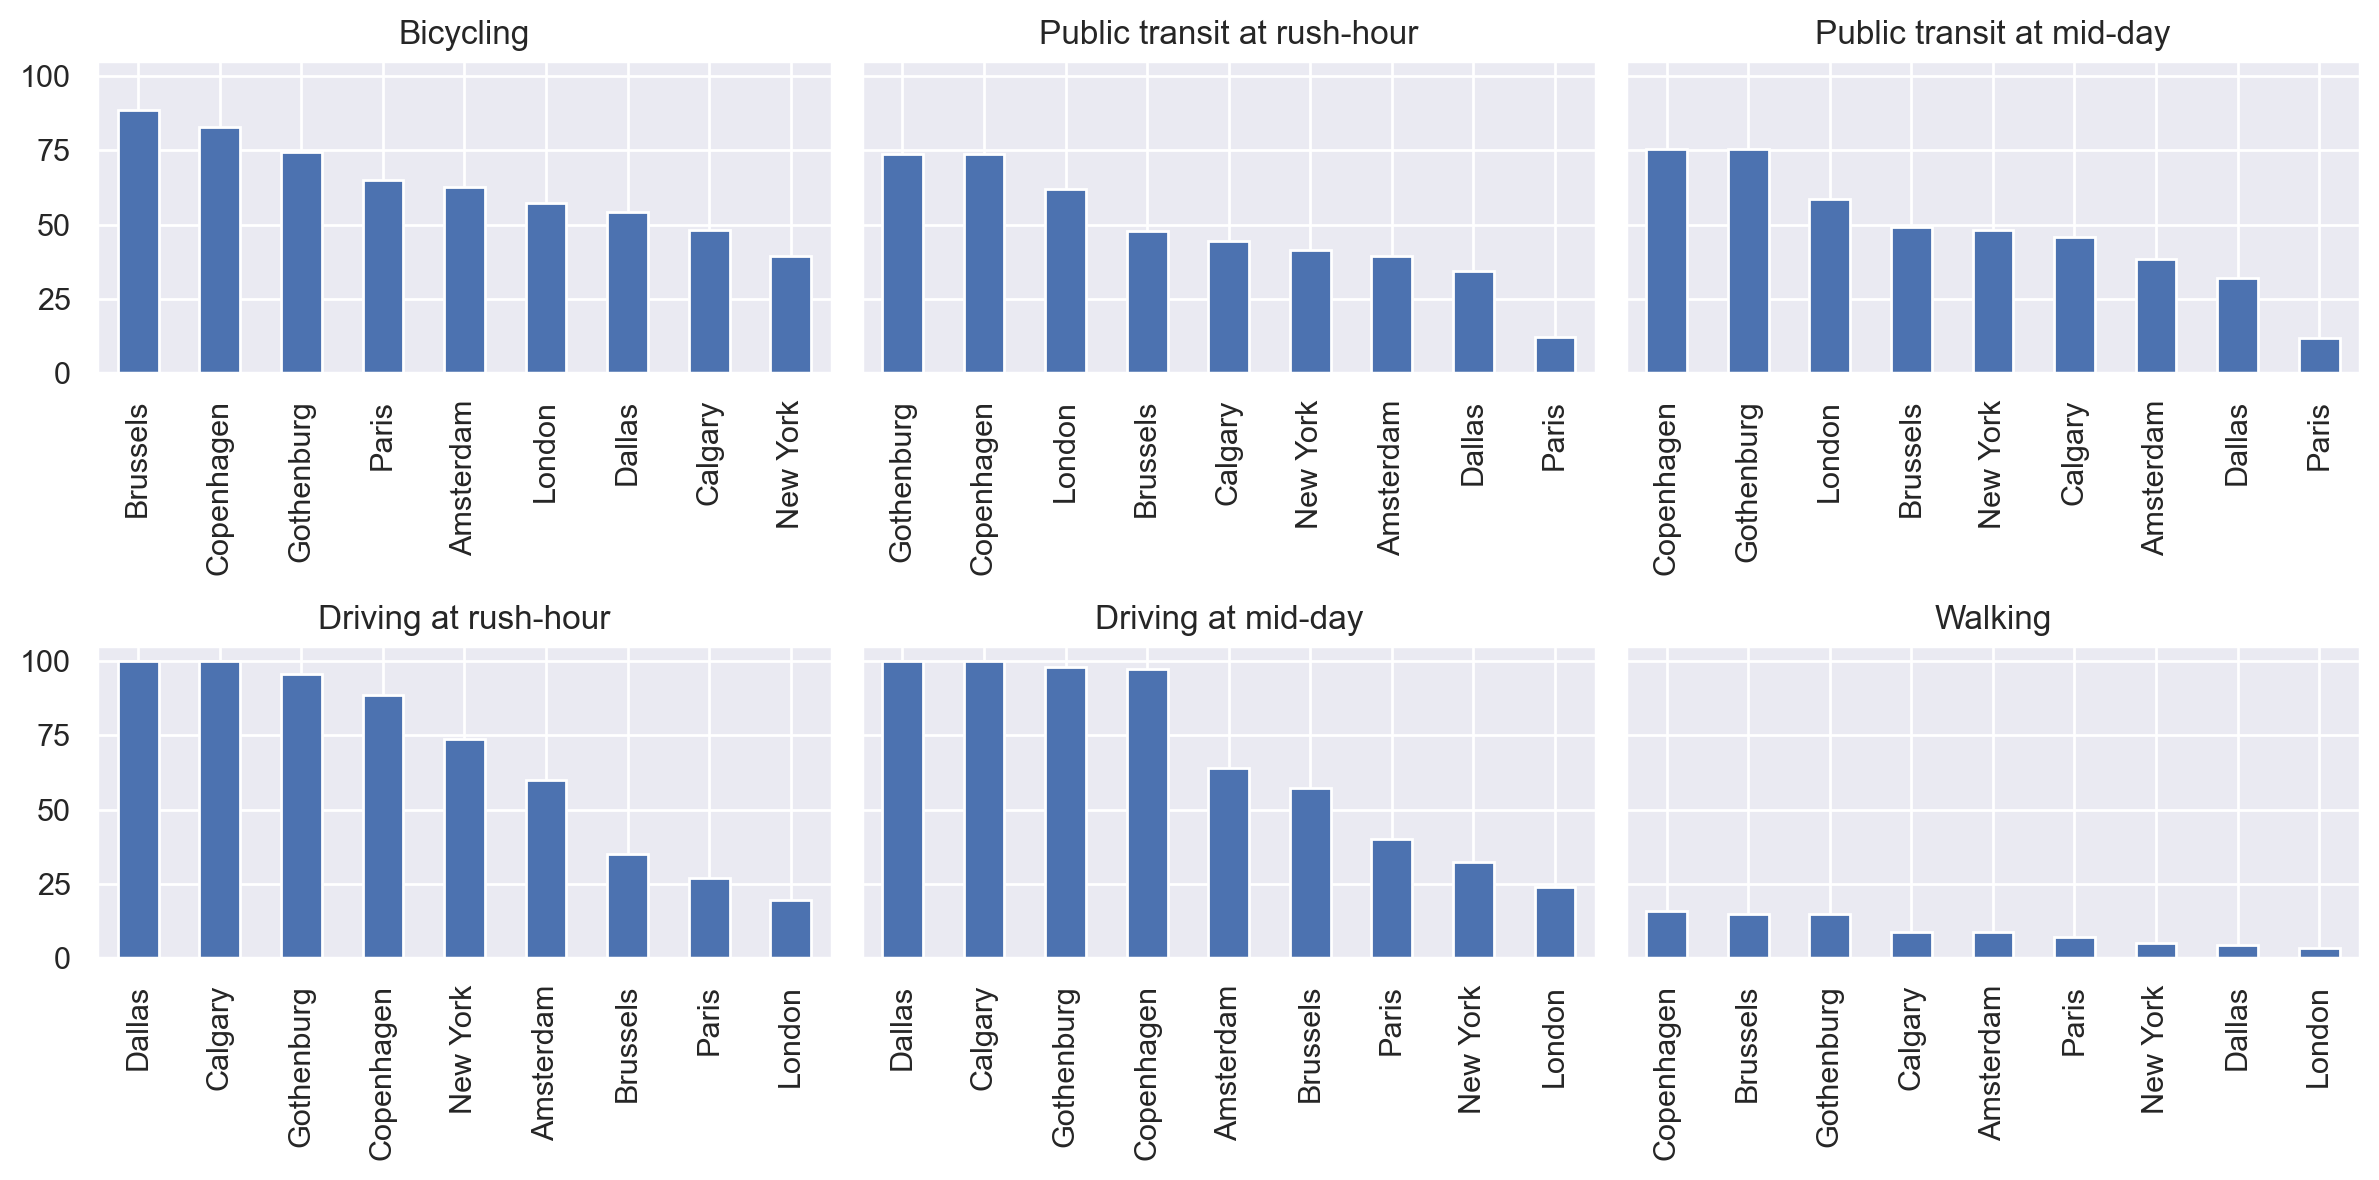

In [13]:
# Select file to base on: 7.5 minutes parking time, 30 minutes budget.
city_props = pd.read_csv(
    os.path.join(DROOT, '4-processed', 'rel-pop-reached', 
                 f'rel-pop-reached-pt7.5min-tb30min.csv'))

city_props = city_props.loc[(city_props.n_consid > 1500)]
city_props = city_props.drop(columns='n_consid')
city_props = city_props.sort_values(by='bike_pop', ascending=False)

graph_vals = city_props.set_index('city').loc[cities][pop_cols]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), dpi=200, tight_layout=True, sharey=True)
axs = axs.flatten()
i = 0
for mode in graph_vals:
    graph_vals[mode].sort_values(ascending=False).plot(kind='bar', ax=axs[i])
    axs[i].set_title(translate[mode])
    axs[i].set_xlabel('')
    i+=1

fig.savefig(os.path.join(DROOT, '5-graphs', 'rel-pop-accessible-summary.png'))

## Plot comparing city coverage with specific details

In [14]:
# Read csv with details for 7.5 minutes parking time and 30 minutes budget.
city_props = pd.read_csv(
    os.path.join(DROOT, '4-processed', 'rel-pop-reached', 
                 f'rel-pop-reached-pt7.5min-tb30min.csv'),
    index_col=['city'])

# Generate working directory
os.makedirs(os.path.join(DROOT, '5-graphs', 'rel-pop-reached'), exist_ok=True)

# Plot all modes in a nice plot
for mode in ['walk_pop', 'bike_pop', 'pt_r_pop', 
             'pt_m_pop', 'car_r_pop', 'car_m_pop']:
    
    city_props = city_props.sort_values(mode, ascending=False)
    fig, ax = plt.subplots(tight_layout=True)
    city_props.loc[city_props.n_consid > 1500, mode].plot(kind='bar', 
                                                          figsize=(18,5),
                                                          ax=ax)
    ax.set_ybound(0, 100)
    ax.set_xlabel('')
    fig.savefig(os.path.join(DROOT, '5-graphs', 'rel-pop-reached', 
                             f'rpr-{mode}-pt7.5-tb30.png'))
    plt.close()
    

## Relative part covered by fastest mode

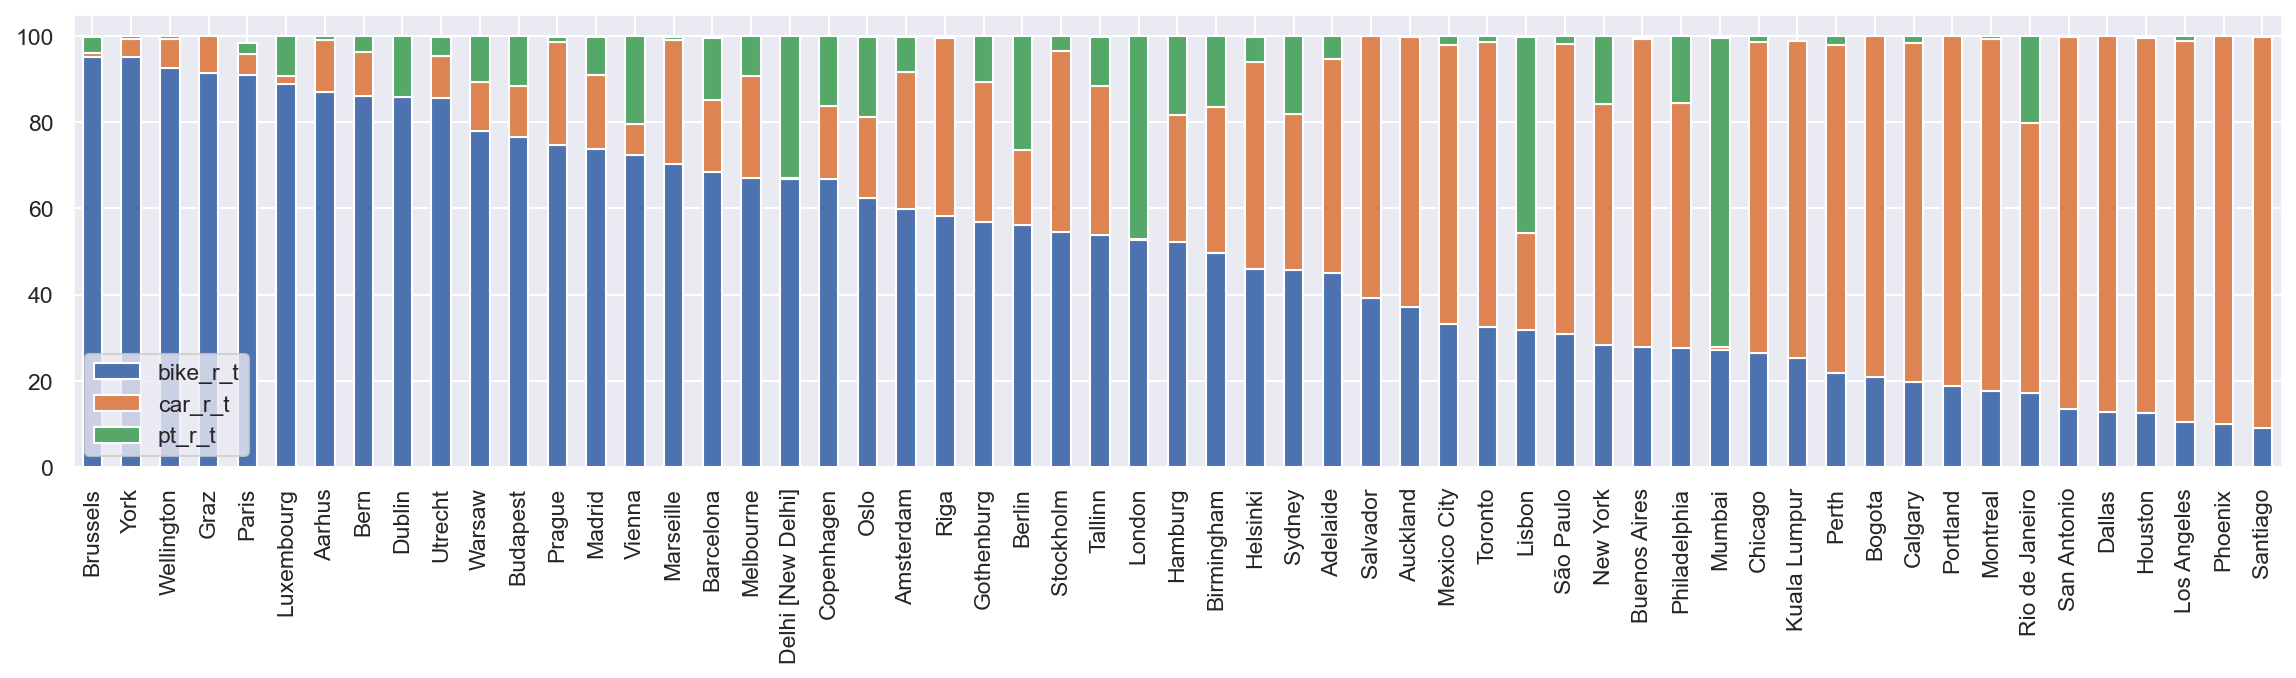

In [29]:
fastest_df = pd.read_csv(
    os.path.join(DROOT, '4-processed', 'rel-pop-fastest-mode', f'rpf-r-pt7.5min.csv'),
    index_col=['city']
).sort_values('bike_r_t', ascending=False)

# Generate plot
fig, ax = plt.subplots(figsize=(int(len(fastest_df) / 3), 4), dpi=150)
fastest_df.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('')
plt.savefig(os.path.join(DROOT, '5-graphs', 'rel-pop-fastest-mode.png'))